Enter TED Talk Name: Do schools kill creativity?

Closest Match Found: Do schools kill creativity?

Suggested TED Talks for 'Do schools kill creativity?':

1. Do schools kill creativity?
2. Bring on the learning revolution!
3. Changing education paradigms
4. How to escape education's death valley
5. Watson, Jeopardy and me, the obsolete know-it-all
6. The child-driven education
7. The secrets I find on the mysterious ocean floor
8. Use data to build better schools
9. 4 lessons from robots about being human
10. Help for kids the education system ignores

Individual Model Accuracies:
SVC Accuracy: 0.67
Logistic Regression Accuracy: 0.69
Random Forest Accuracy: 0.65
XGBoost Accuracy: 0.61
Gradient Boosting Accuracy: 0.61

Stacking Accuracies:
Stacking Accuracy with Logistic Regression: 0.68
Stacking Accuracy with Random Forest: 0.69
Stacking Accuracy with SVC: 0.69
Stacking Accuracy with XGBoost: 0.62
Stacking Accuracy with Gradient Boosting: 0.68

Best Model: Stacking with SVC with Accur

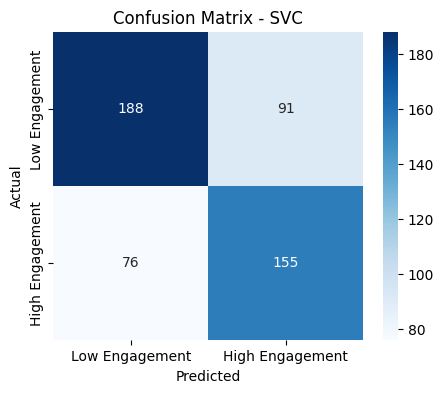

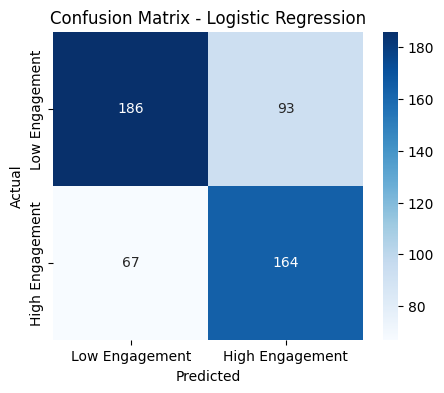

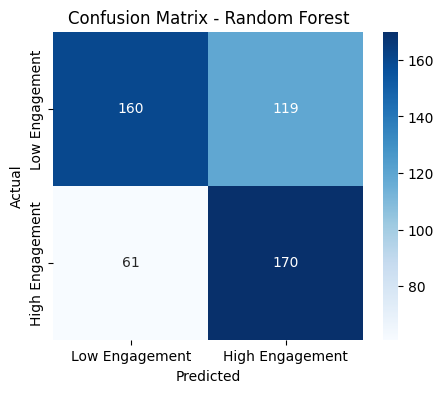

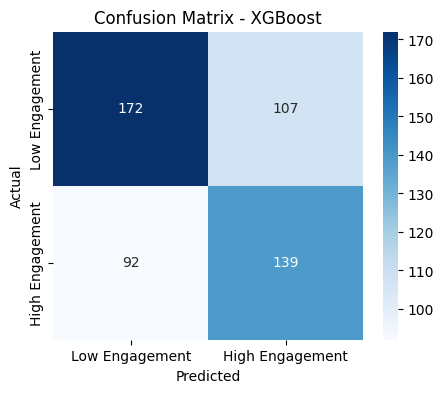

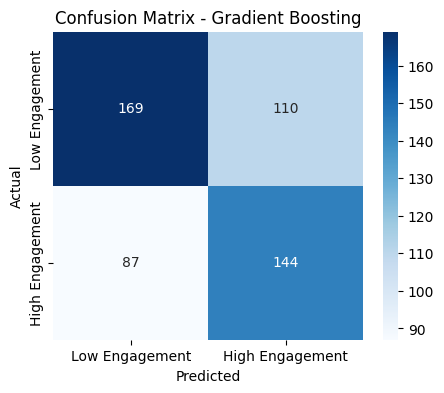

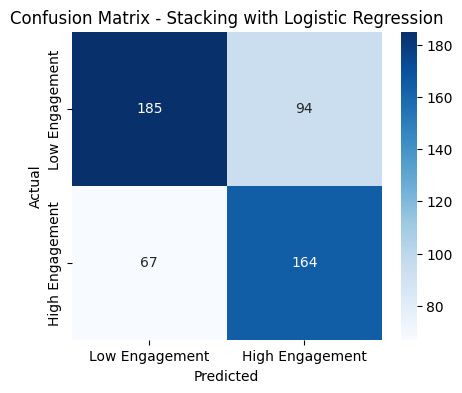

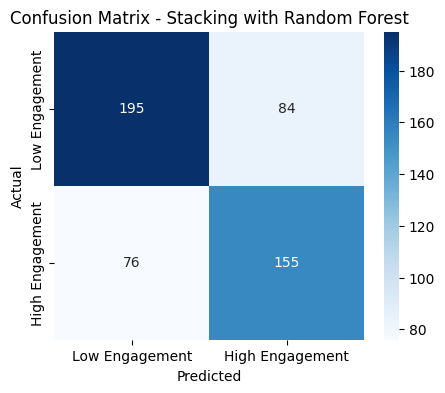

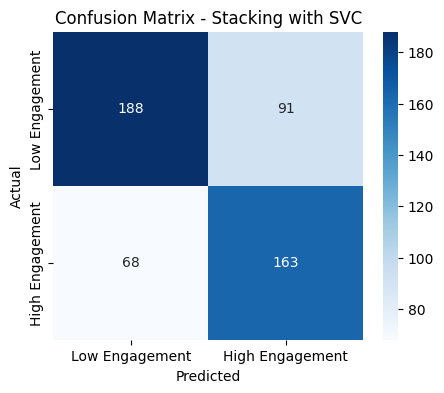

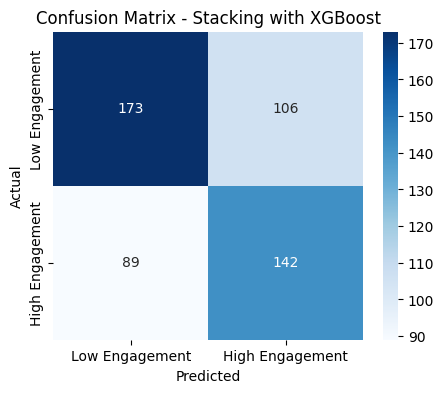

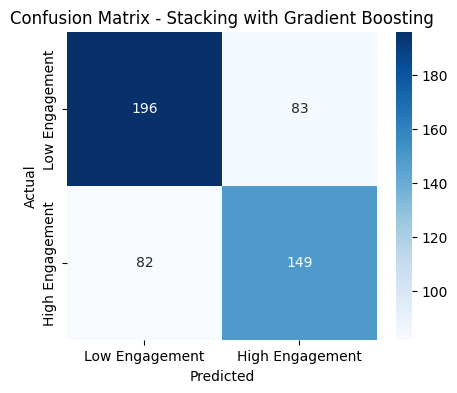

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import difflib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('/content/ted_main_dataset.csv')

# Combine relevant features for recommendation
df.fillna('', inplace=True)
df['combined_features'] = (
    df['title'] + ' ' +
    df['main_speaker'] + ' ' +
    df['description'] + ' ' +
    df['tags'] + ' ' +
    df['speaker_occupation']
)

# Create a target variable based on 'views'
df['views'] = df['views'].fillna(0).astype(float)  # Ensure views are numeric
median_views = df['views'].median()
df['engagement'] = (df['views'] > median_views).astype(int)

# Convert text data into numerical values using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, min_df=5, max_df=0.8)
feature_vectors = vectorizer.fit_transform(df['combined_features'])

# Compute cosine similarity
similarity = cosine_similarity(feature_vectors)

# Create a list of all TED Talk titles
list_of_all_titles = df['title'].tolist()

# --- User Input for Recommendation ---
tedtalk_name = input("Enter TED Talk Name: ")

# Find close matches for the input TED Talk name
find_close_match = difflib.get_close_matches(tedtalk_name, list_of_all_titles)
if not find_close_match:
    print("\nNo matching TED Talks found. Please check the input and try again.")
else:
    close_match = find_close_match[0]
    print(f"\nClosest Match Found: {close_match}")

    index = df[df.title == close_match].index[0]
    similarity_scores = list(enumerate(similarity[index]))
    sorted_similar_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)

    print(f"\nSuggested TED Talks for '{tedtalk_name}':\n")
    for i, tedtalk in enumerate(sorted_similar_scores[:10], start=1):
        index = tedtalk[0]
        title_from_index = df.loc[index, 'title']
        print(f"{i}. {title_from_index}")

# --- Model Implementation ---

# Prepare metadata for classification
X = feature_vectors
y = df['engagement']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Individual Models
svc_model = SVC(kernel='linear', probability=True, random_state=42)
svc_model.fit(X_train, y_train)
svc_accuracy = accuracy_score(y_test, svc_model.predict(X_test))

logistic_model = LogisticRegression(random_state=42, max_iter=1000)
logistic_model.fit(X_train, y_train)
logistic_accuracy = accuracy_score(y_test, logistic_model.predict(X_test))

rf_model = RandomForestClassifier(random_state=42, n_estimators=200, max_depth=10)
rf_model.fit(X_train, y_train)
rf_accuracy = accuracy_score(y_test, rf_model.predict(X_test))

xgb_model = xgb.XGBClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
xgb_accuracy = accuracy_score(y_test, xgb_model.predict(X_test))

gb_model = GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
gb_model.fit(X_train, y_train)
gb_accuracy = accuracy_score(y_test, gb_model.predict(X_test))

print(f"\nIndividual Model Accuracies:")
print(f"SVC Accuracy: {svc_accuracy:.2f}")
print(f"Logistic Regression Accuracy: {logistic_accuracy:.2f}")
print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"XGBoost Accuracy: {xgb_accuracy:.2f}")
print(f"Gradient Boosting Accuracy: {gb_accuracy:.2f}")

# Stacking Classifiers
stacking_lr = StackingClassifier(
    estimators=[('svc', svc_model), ('logistic', logistic_model), ('rf', rf_model)],
    final_estimator=LogisticRegression(random_state=42)
)
stacking_lr.fit(X_train, y_train)
stacking_lr_accuracy = accuracy_score(y_test, stacking_lr.predict(X_test))

stacking_rf = StackingClassifier(
    estimators=[('svc', svc_model), ('logistic', logistic_model), ('rf', rf_model)],
    final_estimator=RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
)
stacking_rf.fit(X_train, y_train)
stacking_rf_accuracy = accuracy_score(y_test, stacking_rf.predict(X_test))

stacking_svc = StackingClassifier(
    estimators=[('svc', svc_model), ('logistic', logistic_model), ('rf', rf_model)],
    final_estimator=SVC(kernel='linear', probability=True, random_state=42)
)
stacking_svc.fit(X_train, y_train)
stacking_svc_accuracy = accuracy_score(y_test, stacking_svc.predict(X_test))

stacking_xgb = StackingClassifier(
    estimators=[('gb', gb_model), ('xgb', xgb_model)],
    final_estimator=xgb.XGBClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3, use_label_encoder=False, eval_metric='logloss')
)
stacking_xgb.fit(X_train, y_train)
stacking_xgb_accuracy = accuracy_score(y_test, stacking_xgb.predict(X_test))

stacking_gb = StackingClassifier(
    estimators=[('svc', svc_model), ('logistic', logistic_model), ('rf', rf_model), ('gb', gb_model)],
    final_estimator=GradientBoostingClassifier(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)
)
stacking_gb.fit(X_train, y_train)
stacking_gb_accuracy = accuracy_score(y_test, stacking_gb.predict(X_test))

print(f"\nStacking Accuracies:")
print(f"Stacking Accuracy with Logistic Regression: {stacking_lr_accuracy:.2f}")
print(f"Stacking Accuracy with Random Forest: {stacking_rf_accuracy:.2f}")
print(f"Stacking Accuracy with SVC: {stacking_svc_accuracy:.2f}")
print(f"Stacking Accuracy with XGBoost: {stacking_xgb_accuracy:.2f}")
print(f"Stacking Accuracy with Gradient Boosting: {stacking_gb_accuracy:.2f}")

# Identify the Best Model
best_accuracy = max(svc_accuracy, logistic_accuracy, rf_accuracy, gb_accuracy, xgb_accuracy,
                    stacking_lr_accuracy, stacking_rf_accuracy, stacking_svc_accuracy, stacking_xgb_accuracy, stacking_gb_accuracy)

if best_accuracy == stacking_lr_accuracy:
    best_model = "Stacking with Logistic Regression"
elif best_accuracy == stacking_rf_accuracy:
    best_model = "Stacking with Random Forest"
elif best_accuracy == stacking_svc_accuracy:
    best_model = "Stacking with SVC"
elif best_accuracy == stacking_xgb_accuracy:
    best_model = "Stacking with XGBoost"
elif best_accuracy == stacking_gb_accuracy:
    best_model = "Stacking with Gradient Boosting"
elif best_accuracy == svc_accuracy:
    best_model = "SVC"
elif best_accuracy == logistic_accuracy:
    best_model = "Logistic Regression"
elif best_accuracy == rf_accuracy:
    best_model = "Random Forest"
elif best_accuracy == gb_accuracy:
    best_model = "Gradient Boosting"
elif best_accuracy == xgb_accuracy:
    best_model = "XGBoost"

print(f"\nBest Model: {best_model} with Accuracy: {best_accuracy:.2f}")
# --- Confusion Matrix Visualization ---
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Low Engagement', 'High Engagement'],
                yticklabels=['Low Engagement', 'High Engagement'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Generate Confusion Matrices
models = {
    "SVC": svc_model, "Logistic Regression": logistic_model,
    "Random Forest": rf_model, "XGBoost": xgb_model, "Gradient Boosting": gb_model
}

for model_name, model in models.items():
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, model_name)

# Confusion Matrices for Stacking Models
stacking_models = {"Stacking with Logistic Regression": stacking_lr, "Stacking with Random Forest": stacking_rf, "Stacking with SVC": stacking_svc, "Stacking with XGBoost": stacking_xgb,"Stacking with Gradient Boosting": stacking_gb}

for model_name, model in stacking_models.items():
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, model_name)